In [1]:
# Import required packages
import warnings

warnings.filterwarnings("ignore")  # Suppress warning messages
import pickle  # For model serialization
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, \
    log_loss  # Model evaluation metrics
import pandas as pd  # Data manipulation
import matplotlib.pyplot as plt  # Plotting
from scipy import stats  # Statistical functions
import seaborn as sns  # Statistical visualizations 
from sklearn import preprocessing  # Data preprocessing
import numpy as np  # Numerical operations

# Survey analysis - Part 2
This notebook is the second part of the survey analysis. It contains the correlation analysis for destination choice, the multinominal logistic regression model and the additional analyses for the Agent-based model.

## Loading data
Loads required data from the survey. SD3 represents education and combines various measured levels into one and sets them in the right order. The data is scaled and the single variables are joined with the factors calculated in Statistics1.ipynb.

In [3]:
# Load and clean raw survey data
raw_raw_data = pd.read_excel(
    "PADM-PA Survey 2_July 17, 2025_13.07_final.xlsx",
    sheet_name="Sheet0").dropna().reset_index(drop=True)
choices = raw_raw_data["DC1"]  # Extract destination choices

# Data preprocessing
raw_raw_data["HE1"] = 1 - raw_raw_data["HE1"]  # Invert HE1 scale
raw_raw_data['SD3'] = raw_raw_data['SD3'].replace({6: 4})  # Recode education levels
raw_raw_data['SD3'] = raw_raw_data['SD3'].replace({7: 6})

# Select variables and standardize
raw_data = raw_raw_data[
    ["HE1", "HE3", "REF1", "REH1", "REP1", "SEV1", "SEVS1", "DC1", "SD1", "SD2", "SD3", "SD4", "SD5", "SD6", "SEC1"]]
raw_data_columns = raw_data.columns
raw_data = pd.DataFrame(preprocessing.StandardScaler().fit_transform(raw_data))
raw_data.columns = raw_data_columns
raw_data[["EI5", "EI6", "DC1"]] = raw_raw_data[["EI5", "EI6", "DC1"]]  # Keep original values for these variables

# Load factor scores from previous analysis
factors_scores = pd.read_excel(
    r"reg_results_FINAL\factor_scores.xlsx")

# Combine standardized variables with factor scores
full_data = pd.concat([raw_data,factors_scores],axis=1) 

Below the respodents get divided into groups with low and high evacuation intention

In [4]:
# Split respondents into evacuation and non-evacuation groups based on intention scores
df_not_evac = full_data[full_data['EI5'] > full_data['EI6']]  # Higher pre-evacuation intention
df_evac = full_data[full_data['EI5'] <= full_data['EI6']]  # Higher post-evacuation intention

# Display group sizes
print("Number of records where EI5 > EI6:", len(df_not_evac))
print("Number of records where EI5 <= EI6:", len(df_evac))

# Compare mean evacuation intention scores between groups
print("\nMean values for group where EI5 > EI6 (non-evacuees):")
print("EI5:", df_not_evac['EI5'].mean())
print("EI6:", df_not_evac['EI6'].mean())

print("\nMean values for group where EI5 <= EI6 (evacuees):")
print("EI5:", df_evac['EI5'].mean())
print("EI6:", df_evac['EI6'].mean())


Number of records where EI5 > EI6: 76
Number of records where EI5 <= EI6: 378

Mean values for group where EI5 > EI6 (non-evacuees):
EI5: 4.078947368421052
EI6: 2.236842105263158

Mean values for group where EI5 <= EI6 (evacuees):
EI5: 2.2301587301587302
EI6: 4.132275132275132


Respondents that did not know where to evacuate to or had chosen the option "other" are removed from the data.

In [5]:
# Remove rows where DC1 equals 4 or 5
df_evac = df_evac[~df_evac['DC1'].isin([4, 5])]
print(len(df_evac))
df_not_evac["DC1"] = 4
df_all = pd.concat([df_evac,df_not_evac],axis=0).drop(columns=['EI5','EI6'])
print(len(df_evac))

362
362


## Choice distribution
Below the distribution of choices is given.

In [6]:
perc = df_all.groupby(by="DC1").count()["HE1"]#.divide(sum( df_all.groupby(by="DC1").count()["HE1"]))
print(perc)

DC1
1.0    239
2.0     95
3.0     28
4.0     76
Name: HE1, dtype: int64


## Destination choice correlations
The two cells below provide two representations of the correlations and their significance.

In [7]:
import pandas as pd
from scipy.stats import pearsonr

# Calculate correlations between each destination choice and all other variables
# For each choice (1-4), converts target to binary (1 if chosen, 0 if not) and correlates with other variables

for i in [1, 2, 3, 4]:
    # Prepare data - combine evacuation datasets and convert choice variable to binary
    df_all = pd.concat([df_evac, df_not_evac], axis=0).drop(columns=['EI5', 'EI6'])
    choice_df = df_all
    choice_df["DC1"] = choice_df["DC1"].apply(lambda x: 1 if x == i else 0)

    target_var = 'DC1'

    # Calculate descriptive statistics
    mean = choice_df[target_var].mean()
    std = choice_df[target_var].std()

    # Calculate correlations and p-values between choice and all other variables
    correlations = {}
    p_values = {}
    for col in choice_df.columns:
        if col == target_var:
            continue
        r, p = pearsonr(choice_df[target_var], choice_df[col])
        correlations[col] = r
        p_values[col] = p

    # Format and print results with significance levels
    # *** p<0.001, ** p<0.01, * p<0.05
    print(f"\nChoice {i}:")
    print(f"Variable: {target_var}")
    print(f"Mean: {mean:.2f}")
    print(f"Standard Deviation: {std:.2f}")
    print("\nCorrelations with other variables:")
    for var, r in correlations.items():
        p = p_values[var]
        sig = ''
        if p < 0.001:
            sig = '***'
        elif p < 0.01:
            sig = '**'
        elif p < 0.05:
            sig = '*'
        print(f"{var:10}: r = {r:.2f} {sig} (p = {p:.3f})") 


Choice 1:
Variable: DC1
Mean: 0.55
Standard Deviation: 0.50

Correlations with other variables:
HE1       : r = 0.01  (p = 0.798)
HE3       : r = 0.02  (p = 0.619)
REF1      : r = 0.23 *** (p = 0.000)
REH1      : r = -0.07  (p = 0.137)
REP1      : r = -0.01  (p = 0.778)
SEV1      : r = 0.04  (p = 0.440)
SEVS1     : r = 0.05  (p = 0.329)
SD1       : r = -0.01  (p = 0.851)
SD2       : r = 0.07  (p = 0.167)
SD3       : r = 0.01  (p = 0.901)
SD4       : r = 0.05  (p = 0.313)
SD5       : r = 0.01  (p = 0.770)
SD6       : r = -0.02  (p = 0.703)
SEC1      : r = -0.02  (p = 0.646)
SE        : r = 0.10 * (p = 0.039)
RA        : r = -0.09  (p = 0.051)
PPA       : r = -0.00  (p = 0.933)
NPA       : r = 0.01  (p = 0.779)
EI        : r = 0.24 *** (p = 0.000)
L         : r = 0.06  (p = 0.240)
HPA       : r = -0.08  (p = 0.077)
FPA       : r = 0.29 *** (p = 0.000)
ECB       : r = 0.01  (p = 0.821)
SC        : r = 0.04  (p = 0.360)

Choice 2:
Variable: DC1
Mean: 0.22
Standard Deviation: 0.41

Correla

In [8]:
import pandas as pd
from scipy.stats import pearsonr

# Dictionary to store correlation results for each destination choice
results = {}
# List of destination choices names for column labels
choice_list = ["Family", "Hotel", "Public shelter", "Stay"]

# Calculate correlations for each destination choice (1=Family, 2=Hotel, 3=Public shelter, 4=Stay)
for i in [1, 2, 3, 4]:
    # Combine evacuation and non-evacuation groups, removing intention scores
    df_all = pd.concat([df_evac, df_not_evac], axis=0).drop(columns=['EI5', 'EI6'])

    # Create binary variable for current destination choice (1 if chosen, 0 otherwise)
    choice_df = df_all.copy()
    choice_df["DC1"] = choice_df["DC1"].apply(lambda x: 1 if x == i else 0)

    # Calculate correlations between destination choice and all other variables
    correlations = {}
    for col in choice_df.columns:
        if col == "DC1":
            continue
        # Calculate Pearson correlation and p-value
        r, p = pearsonr(choice_df["DC1"], choice_df[col])

        # Add significance stars based on p-value
        # *** p<0.001, ** p<0.01, * p<0.05
        if p < 0.001:
            sig = '***'
        elif p < 0.01:
            sig = '**'
        elif p < 0.05:
            sig = '*'
        else:
            sig = ''

        # Store formatted correlation coefficient with significance stars
        correlations[col] = f"{r:.2f}{sig}"

    # Store correlations for current destination choice
    results[f'{choice_list[i - 1]}'] = correlations

# Create DataFrame with correlations: rows=variables, columns=destination choices
cor_df = pd.DataFrame(results)
cor_df.index.name = "Variable"

# Display correlation matrix
print(cor_df) 

           Family    Hotel Public shelter      Stay
Variable                                           
HE1          0.01     0.06           0.03    -0.11*
HE3          0.02     0.07           0.02    -0.12*
REF1      0.23***   -0.11*           0.03  -0.20***
REH1        -0.07  0.21***          -0.00   -0.13**
REP1        -0.01     0.04        0.17***   -0.14**
SEV1         0.04     0.06           0.06   -0.16**
SEVS1        0.05     0.09           0.09  -0.22***
SD1         -0.01    -0.03          -0.07      0.09
SD2          0.07     0.03          -0.08     -0.08
SD3          0.01     0.00           0.09     -0.07
SD4          0.05    -0.02           0.05     -0.07
SD5          0.01    -0.03           0.06     -0.02
SD6         -0.02     0.04          -0.04      0.00
SEC1        -0.02     0.06           0.05     -0.07
SE          0.10*    -0.02           0.00    -0.12*
RA          -0.09     0.01          -0.09   0.17***
PPA         -0.00     0.07        0.19***  -0.19***
NPA         

## Multinominal logistic regression model
Before training the model, it is checked through two methods which variables are the most relevant.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# Use all numeric predictors
X = df_all.drop(columns=['DC1'])
y = df_all['DC1']

logreg = LogisticRegression(max_iter=10000, solver='saga')
rfe = RFE(logreg, n_features_to_select=10)  # Try selecting top 10 for example
fit = rfe.fit(X, y)

# Get ranking and mask (which features are selected)
feature_ranking = pd.Series(fit.ranking_, index=X.columns).sort_values()
print("Feature ranking (1=best):")
print(feature_ranking)

selected_features = X.columns[fit.support_]
print("Most relevant features according to RFE:")
print(selected_features.tolist())


Feature ranking (1=best):
REH1      1
REF1      1
SEVS1     1
REP1      1
RA        1
SD2       1
EI        1
PPA       1
HPA       1
FPA       1
SD3       2
L         3
SD5       4
SD1       5
NPA       6
SD4       7
SEV1      8
SEC1      9
SE       10
SC       11
SD6      12
HE3      13
ECB      14
HE1      15
dtype: int64
Most relevant features according to RFE:
['REF1', 'REH1', 'REP1', 'SEVS1', 'SD2', 'RA', 'PPA', 'EI', 'HPA', 'FPA']


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest classifier with fixed random state for reproducibility
forest = RandomForestClassifier(random_state=42)

# Train the Random Forest model on the feature matrix X and target variable y
forest.fit(X, y)

# Extract feature importance scores from the trained model
importances = forest.feature_importances_

# Create a sorted Series of feature importances with feature names as index
feat_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Display the feature importances in descending order
print("Feature importances (Random Forest):")
print(feat_importance)


Below the model is trained and evaluated 100 times to check the average accuracy. The current settings are not representative since the model used for the statistical differs from the ABM one since the ABM includes the public shelter choice, while the survey part does not


In [11]:
def train_and_evaluate_model(seed):
    """
    Train and evaluate a logistic regression model with stratified sampling.
    
    Args:
        seed (int): Random seed for reproducibility
        
    Returns:
        tuple: Model performance metrics (accuracy, precision, recall, f1, confusion matrix)
    """
    # Combine evacuation and non-evacuation datasets
    df_all = pd.concat([df_evac, df_not_evac], axis=0).drop(columns=['EI5', 'EI6'])

    # Create stratified test set with 20 samples per class
    sample_df = df_all.groupby('DC1', group_keys=False).apply(lambda x: x.sample(n=20, random_state=seed))
    sample_test_X = sample_df.drop(columns="DC1")  # Features for testing
    sample_test_Y = sample_df[["DC1"]]  # Target variable for testing

    # Create training set from remaining data
    remainder_df = df_all.drop(sample_df.index)
    remainder_df_X = remainder_df.drop(columns="DC1")  # Features for training
    remainder_df_Y = remainder_df[["DC1"]]  # Target variable for training

    # Train logistic regression model with balanced class weights
    model = LogisticRegression(random_state=seed,
                               solver="saga",
                               class_weight="balanced").fit(remainder_df_X, remainder_df_Y)

    # Make predictions on test set
    y_pred = model.predict(sample_test_X)

    # Calculate performance metrics
    accuracy = accuracy_score(sample_test_Y, y_pred)
    precision = precision_score(sample_test_Y, y_pred, average="micro")
    recall = recall_score(sample_test_Y, y_pred, average="micro")
    f1 = f1_score(sample_test_Y, y_pred, average="micro")
    conf_matrix = confusion_matrix(sample_test_Y, y_pred)

    filename = 'reg_results_FINAL/finalized_model.sav'
    pickle.dump(model, open(filename, 'wb'))
    loaded_model = pickle.load(open(filename, 'rb'))
    return accuracy, precision, recall, f1, conf_matrix


# Perform multiple model evaluations with different random seeds
metrics = []
conf_matrices = []
n_iterations = 100

# Run model training and evaluation n_iterations times
for i in range(n_iterations):
    acc, prec, rec, f1, conf_mat = train_and_evaluate_model(i)
    metrics.append((acc, prec, rec, f1))
    conf_matrices.append(conf_mat)

# Calculate average performance metrics across all iterations
avg_metrics = np.mean(metrics, axis=0)
avg_conf_matrix = np.mean(conf_matrices, axis=0)

# Print results
print(f"Average Accuracy: {avg_metrics[0]:.3f}")
print(f"Average Precision: {avg_metrics[1]:.3f}")
print(f"Average Recall: {avg_metrics[2]:.3f}")
print(f"Average F1 Score: {avg_metrics[3]:.3f}")
print("\nAverage Confusion Matrix:")
print(avg_conf_matrix)

Average Accuracy: 0.430
Average Precision: 0.430
Average Recall: 0.430
Average F1 Score: 0.430

Average Confusion Matrix:
[[ 9.25  4.43  2.68  3.64]
 [ 5.68  8.89  2.67  2.76]
 [ 5.58  5.06  4.87  4.49]
 [ 3.54  2.67  2.4  11.39]]


## Agent-based input data
Cell below scales three variabls and then saves them for the use in the agent-based model for weight calculation or cue perception


In [ ]:
# Import required libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Combine evacuation and non-evacuation datasets, removing intention scores
df_all = pd.concat([df_evac, df_not_evac], axis=0).drop(columns=['EI5', 'EI6'])

# Extract the three variables needed for agent weights
weights = df_all[["RA", "EI", "ECB"]].copy()

# Initialize two scalers with different ranges:
# (-1,1) for Risk Assessment (RA) to allow for negative risk perception
# (0,1) for Evacuation Intention (EI) and Expected Cost-Benefit (ECB)
scaler_neg1_1 = MinMaxScaler(feature_range=(-1, 1))
scaler_0_1 = MinMaxScaler(feature_range=(0, 1))

# Scale each variable using the appropriate scaler
weights = weights.assign(
    RA=scaler_neg1_1.fit_transform(weights[["RA"]]),  # Scale RA to [-1,1]
    EI=scaler_0_1.fit_transform(weights[["EI"]]),  # Scale EI to [0,1]
    ECB=scaler_0_1.fit_transform(weights[["ECB"]])  # Scale ECB to [0,1]
)

# Print first 3 rows and any rows with missing values
print(weights.head(3), weights[weights.isna().any(axis=1)])

# Ensure column names are properly set
weights.columns = ["RA", "EI", "ECB"]

# Save processed weights to CSV file for use in agent-based model
weights.to_csv("reg_results_FINAL/weights.csv") 

Gives an histogram

Text(0.5, 0, 'Risk Assessment intensity')

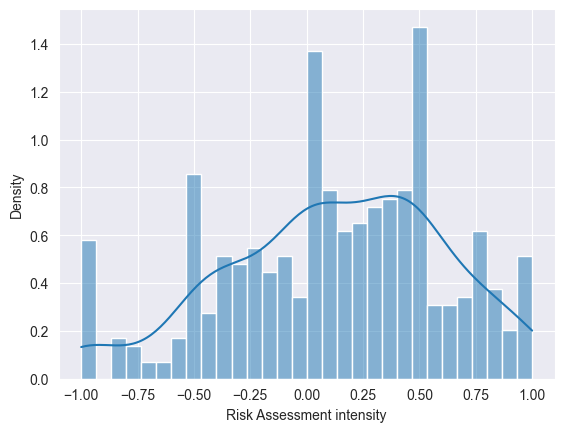

In [51]:
sns.histplot(weights["RA"], label="Original", kde=True, stat='density', bins=30)
plt.xlabel('Risk Assessment intensity')


Code below compares the bootstrapped data and the actual data and provides suplots of this comparison

F1 Score: 0.675
Confusion Matrix:
[[13  7]
 [ 6 14]]
F1 Score: 0.525
Confusion Matrix:
[[20  0]
 [19  1]]
F1 Score: 0.500
Confusion Matrix:
[[20  0]
 [20  0]]
F1 Score: 0.600
Confusion Matrix:
[[20  0]
 [16  4]]


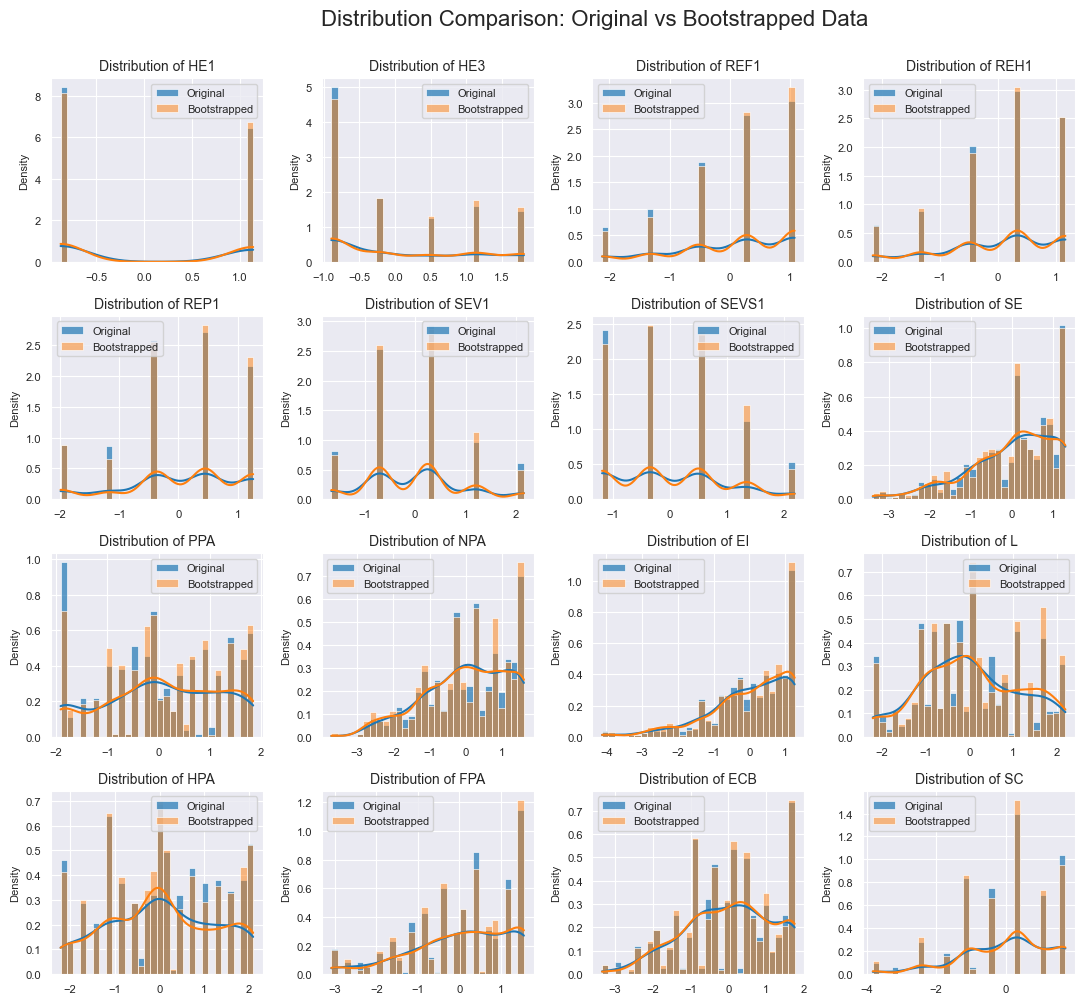

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get probabilities and add column with highest probability choice
# probs = hotel_model.predict_proba(popu)
choice_names = ['Family', 'Hotel', 'Public shelter', 'Stay']
pedict_results['predicted_choice'] = [i for i in np.argmax(pedict_results, axis=1)]

n_population = 1000
predictors_df = df_all[["HE1","HE3","REF1","REH1","REP1","SEV1","SEVS1","SE","PPA","NPA","EI","L","HPA","FPA","ECB","SC","DC1"]]
predictors_df_boot = predictors_df.drop(columns="DC1")
resampled_agents = predictors_df.sample(
    n=n_population,
    replace=True,
    random_state=42
).reset_index(drop=True)

n_features = predictors_df_boot.shape[1]
feature_names = predictors_df_boot.columns

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 10))
fig.suptitle('Distribution Comparison: Original vs Bootstrapped Data', fontsize=16, y=1)
axes = axes.flatten()

# Create empty lists to store plot objects for legend
orig_plots = []
boot_plots = []

for i, col in enumerate(feature_names):
    ax = axes[i]

    # Original data plot
    orig = sns.histplot(predictors_df_boot[col],
                       color="#1f77b4",
                       kde=True,
                       stat='density',
                       ax=ax,
                       bins=30,
                        alpha=0.7,
                        label='Original')
    orig_plots.append(orig)

    # Bootstrapped data plot
    boot = sns.histplot(resampled_agents[col],
                        color="#ff7f0e",
                        kde=True,
                        stat='density',
                        ax=ax,
                        bins=30,
                        alpha=0.5,
                        label='Bootstrapped')
    boot_plots.append(boot)

    ax.set_title(f'Distribution of {col}', fontsize=10)
    ax.tick_params(labelsize=8)
    ax.set_xlabel('')
    ax.set_ylabel('Density', fontsize=8)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.subplots_adjust(right=0.9)  # Make room for legend
plt.show()

Code below executes a two-sample Kolmogorov-Smirnov test for the bootstrapped data and actual data to ensure similarity

In [ ]:
def perform_ks_test(df1, df2):
    results = {}
    for column in df1.columns:
        statistic, p_value = stats.ks_2samp(df1[column], df2[column])
        results[column] = {'statistic': statistic, 'p_value': p_value}
    return pd.DataFrame(results).T


# Perform KS test for all columns
ks_results = perform_ks_test(predictors_df_boot, resampled_agents)

# Add significance stars
ks_results['significance'] = ''
ks_results.loc[ks_results['p_value'] < 0.001, 'significance'] = '***'
ks_results.loc[(ks_results['p_value'] < 0.01) & (ks_results['p_value'] >= 0.001), 'significance'] = '**'
ks_results.loc[(ks_results['p_value'] < 0.05) & (ks_results['p_value'] >= 0.01), 'significance'] = '*'

# Display results
print("Kolmogorov-Smirnov test results for each variable:")
print("\nH0: The two samples come from the same distribution")
print("H1: The two samples come from different distributions\n")
print("Significance levels: *** p<0.001, ** p<0.01, * p<0.05\n")
print(ks_results.sort_values('p_value'))

### MEDIA
Splits the ten question about media trust and frequency and saves them. The valeus for freequency are adjusted so they can directly be used in the ABM.

In [56]:
# Load raw survey data and extract media-related columns (MD1-MD10)
raw_raw_data = pd.read_excel(
    r"C:\Users\roelo\Downloads\Clean_thesis\regression models\PADM-PA Survey 2_July 17, 2025_13.07_final.xlsx",
    sheet_name="Sheet0").dropna().reset_index(drop=True)
media_df = raw_raw_data[["MD1", "MD2", "MD3", "MD4", "MD5", "MD6", "MD7", "MD8", "MD9", "MD10"]]

# Scale trust-related columns (MD6-MD10) to range [0,1]
scaler = MinMaxScaler(feature_range=(0, 1))
media_df[["MD6", "MD7", "MD8", "MD9", "MD10"]] = pd.DataFrame(
    scaler.fit_transform(media_df[["MD6", "MD7", "MD8", "MD9", "MD10"]]))

# Map frequency values (1-5) to actual number of times per year
freq_map = {1: 100, 2: 12, 3: 6, 4: 3, 5: 2}  # 1=daily, 2=monthly, 3=bimonthly, 4=quarterly, 5=biannually
media_df[["MD1", "MD2", "MD3", "MD4", "MD5"]] = media_df[["MD1", "MD2", "MD3", "MD4", "MD5"]].apply(
    lambda x: x.map(freq_map))

# Save processed media weights to CSV
media_df.to_csv("reg_results_FINAL/media_weights.csv")

# Rename columns to meaningful names
media_df.columns = [
    "Freq_SocialMedia",
    "Freq_Radio",
    "Freq_Internet",
    "Freq_Television",
    "Freq_Newspapers",
    "Trust_SocialMedia",
    "Trust_Radio",
    "Trust_Internet",
    "Trust_Television",
    "Trust_Newspapers",
]

# Initialize DataFrames to store frequency counts
counted_df = pd.DataFrame()
counted_df.index = ["2", "3", "6", "12", "100"]  # Frequency values after mapping
counted_df_trust = pd.DataFrame()

# Count occurrences of each frequency value for each media type
for freq_var in ["Freq_SocialMedia", "Freq_Radio", "Freq_Internet", "Freq_Television", "Freq_Newspapers"]:
    counted_df[freq_var] = media_df[freq_var].value_counts().sort_index().values

# Count occurrences of each trust level for each media type
for freq_var in ["Trust_SocialMedia", "Trust_Radio", "Trust_Internet", "Trust_Television", "Trust_Newspapers"]:
    counted_df_trust[freq_var] = media_df[freq_var].value_counts().sort_index().values 

Code below provides an overview of the media trust and fequency per media channel

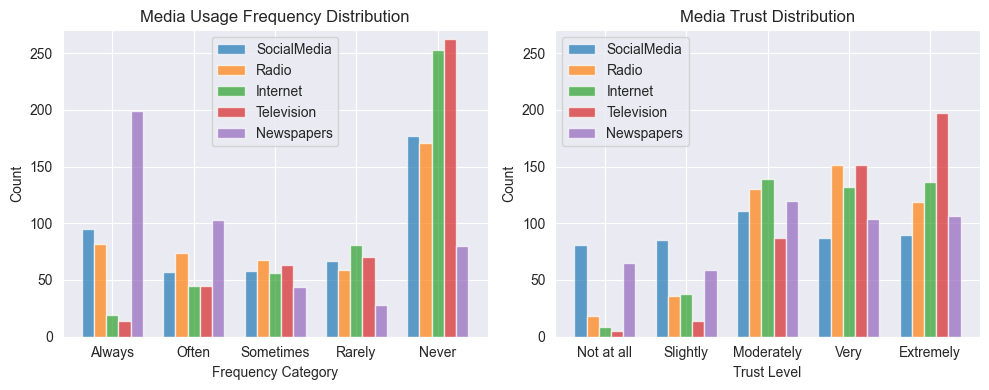

In [57]:
# Create figure with two subplots side by side
import numpy as np
import matplotlib.pyplot as plt

fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(10, 4))

# Set width for each bar and calculate x-axis positions
bar_width = 0.15
x = np.arange(len(counted_df_trust.index))

# Plot trust distribution for each media type
for i, column in enumerate(counted_df_trust.columns):
    # Calculate offset to position bars side by side
    offset = (i - (len(counted_df_trust.columns) - 1) / 2) * bar_width
    label = column.replace('Trust_', '')
    ax1.bar(x + offset, counted_df_trust[column],
            label=label, alpha=0.7, width=bar_width)

# Configure trust distribution plot aesthetics
ax1.set_xticks(x)
ax1.set_xticklabels(['Not at all', 'Slightly', 'Moderately', 'Very', 'Extremely'])
ax1.set_xlabel('Trust Level')
ax1.set_ylabel('Count')
ax1.set_ylim(0, 270)
ax1.legend()
ax1.set_title('Media Trust Distribution')

# Reorder frequency data from highest to lowest frequency
counted_df = counted_df.reindex(index=["100", "12", "6", "3", "2"])

# Plot frequency distribution for each media type
for i, column in enumerate(counted_df.columns):
    offset = (i - (len(counted_df.columns) - 1) / 2) * bar_width
    label = column.replace('Freq_', '')
    ax2.bar(x + offset, counted_df[column],
            label=label, alpha=0.7, width=bar_width)

# Configure frequency distribution plot aesthetics
ax2.set_xticks(x)
ax2.set_xticklabels(['Always', 'Often', 'Sometimes', 'Rarely', 'Never'])
ax2.set_xlabel('Frequency Category')
ax2.set_ylabel('Count')
ax2.set_ylim(0, 270)
ax2.legend()
ax2.set_title('Media Usage Frequency Distribution')

# Adjust layout and display plots
plt.tight_layout() 
plt.show()  

### Social network
Gives the average number of acquaintances 

In [ ]:
SocialNetwork = raw_raw_data["SN"]

In [ ]:
print(f"Mean: {SocialNetwork.mean()}")
print(f"Std: {SocialNetwork.std()}")